# Song recommender

In [42]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import random
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(
    client_id='5b44cad582a94beba3164abb00895da0',
    client_secret='ffbdd308952746b2898b48aff6707331'))
from itertools import chain
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

### Billboard database

In [2]:
url = 'https://www.billboard.com/charts/hot-100'

In [3]:
response = requests.get(url)

In [4]:
response

<Response [200]>

In [5]:
response.content

b'<!doctype html>\n<html class="" lang="">\n<head>\n<meta charset="utf-8">\n<meta http-equiv="X-UA-Compatible" content="IE=edge">\n<meta name="viewport" content="width=device-width, initial-scale=1, user-scalable=no">\n<title>The Hot 100 Chart | Billboard</title>\n<meta name="title" property="title" content="The Hot 100 Chart" />\n<meta name="twitter:site" content="@billboard">\n<meta property="og:site_name" content="Billboard" />\n<meta property="og:type" content="article" />\n<link rel="manifest" href="/manifest.json">\n<style>\n        .chart-pro-access {\n            background-image: url(\'https://www.billboard.com/assets/1603122088/images/piano/chart-pro-access-mb.png?d7e1def6780deb3fea32\');\n        }\n\n        @media (min-width: 769px) {\n            .chart-pro-access {\n                background-image: url(\'https://www.billboard.com/assets/1603122088/images/piano/chart-pro-access-dk.png?d7e1def6780deb3fea32\');\n            }\n        }\n    </style>\n<link rel="canonical"

In [6]:
soup = BeautifulSoup(response.content, 'html.parser')

In [7]:
soup

<!DOCTYPE html>

<html class="" lang="">
<head>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width, initial-scale=1, user-scalable=no" name="viewport"/>
<title>The Hot 100 Chart | Billboard</title>
<meta content="The Hot 100 Chart" name="title" property="title">
<meta content="@billboard" name="twitter:site"/>
<meta content="Billboard" property="og:site_name">
<meta content="article" property="og:type">
<link href="/manifest.json" rel="manifest"/>
<style>
        .chart-pro-access {
            background-image: url('https://www.billboard.com/assets/1603122088/images/piano/chart-pro-access-mb.png?d7e1def6780deb3fea32');
        }

        @media (min-width: 769px) {
            .chart-pro-access {
                background-image: url('https://www.billboard.com/assets/1603122088/images/piano/chart-pro-access-dk.png?d7e1def6780deb3fea32');
            }
        }
    </style>
<link href="/charts/hot-100" rel="canonical"/>
<li

In [8]:
songs = []

for song in soup.select('span.chart-element__information__song.text--truncate.color--primary'):
    songs.append(song.get_text())
    
artists = []
    
for artist in soup.select('span.chart-element__information__artist.text--truncate.color--secondary'):
    artists.append(artist.get_text())
    
lwk = []

for w in soup.select('span.chart-element__meta.text--center.color--secondary.text--last'):
    lwk.append(w.get_text())

pk = []

for w in soup.select('span.chart-element__meta.text--center.color--secondary.text--peak'):
    pk.append(w.get_text())
    
woc = []

for w in soup.select('span.chart-element__meta.text--center.color--secondary.text--week'):
    woc.append(w.get_text())

In [9]:
top_songs = pd.DataFrame({'song':songs,'artist':artists,'last_week':lwk,'peak':pk,'WoC':woc})

In [10]:
top_songs

song                        artist last_week peak WoC
0             Positions                 Ariana Grande         -    1   1
1     Forever After All                    Luke Combs         -    2   1
2                  Mood  24kGoldn Featuring iann dior         1    1  12
3   Laugh Now Cry Later      Drake Featuring Lil Durk         3    2  11
4       Blinding Lights                    The Weeknd         4    1  48
..                  ...                           ...       ...  ...  ..
95             Cardigan                  Taylor Swift        88    1  14
96        Forget Me Too    Machine Gun Kelly & Halsey         -   44   3
97            La Toxica                       Farruko         -   98   1
98         Head & Heart             Joel Corry X MNEK         -   99   1
99  Wine, Beer, Whiskey               Little Big Town         -  100   1

[100 rows x 5 columns]

### Playlist database

In [11]:
offset_range = range(0, 10001, 100)

In [12]:
playlist1 = spotify.user_playlist_tracks(user='spotify', playlist_id='spotify:playlist:6yPiKpy7evrwvZodByKvM9')

In [13]:
playlists = []

for offset_loop in offset_range:
    playlists.append(spotify.user_playlist_tracks(user='spotify', playlist_id='spotify:playlist:6yPiKpy7evrwvZodByKvM9', offset = offset_loop))

In [14]:
playlist_tracks = []

for plays in playlists:
    for playlistx in plays['items']:
        playlist_tracks.append(playlistx['track']['uri'])

In [15]:
len(playlist_tracks)

10000

In [24]:
track_features = []
for track in playlist_tracks:
    try:
        track_features.append(spotify.audio_features(track))
    except:
        pass

Expected id of type track but found type 100+Amazing+Bass+Lines spotify:local:::100+Amazing+Bass+Lines:785
Expected id of type track but found type Alabama+Shakes+performing+Don%27t+Wanna+Fight+Live+on+KCRW spotify:local:::Alabama+Shakes+performing+Don%27t+Wanna+Fight+Live+on+KCRW:251
Expected id of type track but found type Anderson+East+-+Satisfy+Me+-+3_15_2015+-+Riverview+Bungalow%2C+Austin%2C+TX spotify:local:::Anderson+East+-+Satisfy+Me+-+3_15_2015+-+Riverview+Bungalow%2C+Austin%2C+TX:164
Expected id of type track but found type Art+Of+Sleeping+cover+Drake+%27Hotline+Bling%27+for+Like+A+Version spotify:local:::Art+Of+Sleeping+cover+Drake+%27Hotline+Bling%27+for+Like+A+Version:281
Expected id of type track but found type Bahamas+-+Stronger+Than+That+%28Buzzsession%29 spotify:local:::Bahamas+-+Stronger+Than+That+%28Buzzsession%29:172
Expected id of type track but found type CHANSON+_+RE%CC%81PLIQUES+DE+FILMS+%28AVEC+MIRO+BELZIL%29 spotify:local:::CHANSON+_+RE%CC%81PLIQUES+DE+FILMS+%

Expected id of type track but found type Who+Made+Who+-+Space+For+Rent spotify:local:::Who+Made+Who+-+Space+For+Rent:360
Expected id of type track but found type Xavier+Cafeine+-+Gise%CC%80le spotify:local:::Xavier+Cafeine+-+Gise%CC%80le:261
Expected id of type track but found type Xavier+Cafe%CC%81ine+-+La+fin+du+monde spotify:local:::Xavier+Cafe%CC%81ine+-+La+fin+du+monde:292
Expected id of type track but found type Xavier+Cafeine+-+Montreal+%28Cette+ville%29 spotify:local:::Xavier+Cafeine+-+Montreal+%28Cette+ville%29:305
Expected id of type track but found type Wii+Shop+Channel+Music spotify:local:::Wii+Shop+Channel+Music:559
Max Retries reached
Expected id of type track but found type All+You+Need+Is+Love spotify:local:The+Beatles:1967-1970+%5BDisc+1%5D:All+You+Need+Is+Love:228
Expected id of type track but found type Gathering+All+the+Lost+Loves spotify:local:General+Elektriks:Good+City+for+Dreamers:Gathering+All+the+Lost+Loves:168
Expected id of type track but found type Love+You

In [25]:
len(track_features)

9998

In [26]:
track_features[1235]

[{'danceability': 0.538,
  'energy': 0.742,
  'key': 4,
  'loudness': -9.299,
  'mode': 0,
  'speechiness': 0.05,
  'acousticness': 0.00554,
  'instrumentalness': 0.00494,
  'liveness': 0.121,
  'valence': 0.488,
  'tempo': 117.128,
  'type': 'audio_features',
  'id': '2agQZCUDREGuw5yK9FRbBN',
  'uri': 'spotify:track:2agQZCUDREGuw5yK9FRbBN',
  'track_href': 'https://api.spotify.com/v1/tracks/2agQZCUDREGuw5yK9FRbBN',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/2agQZCUDREGuw5yK9FRbBN',
  'duration_ms': 281107,
  'time_signature': 4}]

In [31]:
features_dframe = pd.concat([pd.DataFrame(ft) for ft in track_features])
features_dframe

0  acousticness                                       analysis_url  \
0   NaN       0.09400  https://api.spotify.com/v1/audio-analysis/33xM...   
0   NaN       0.13700  https://api.spotify.com/v1/audio-analysis/3Uny...   
0   NaN       0.59000  https://api.spotify.com/v1/audio-analysis/1w8Q...   
0   NaN       0.32500  https://api.spotify.com/v1/audio-analysis/7J9m...   
0   NaN       0.02310  https://api.spotify.com/v1/audio-analysis/1VZe...   
..  ...           ...                                                ...   
0   NaN       0.12300  https://api.spotify.com/v1/audio-analysis/5jzm...   
0   NaN       0.08230  https://api.spotify.com/v1/audio-analysis/2fmM...   
0   NaN       0.19000  https://api.spotify.com/v1/audio-analysis/60rI...   
0   NaN       0.00824  https://api.spotify.com/v1/audio-analysis/0sEm...   
0   NaN       0.00767  https://api.spotify.com/v1/audio-analysis/4JPE...   

    danceability  duration_ms  energy                      id  \
0          0.310     152560.0   0.445  33xMbeHzmWd6Od0BmLZEUs   
0          0.419     197707.0   0.565  3UnyplmZaq547hwsfOR5yy   
0          0.354     244285.0   0.302  1w8QCSDH4QobcQeT4uMKLm   
0          0.727     249940.0   0.785  7J9mBHG4J2eIfDAv5BehKA   
0          0.571     278320.0   0.724  1VZedwJj1gyi88WFRhfThb   
..           ...          ...     ...                     ...   
0          0.651     200480.0   0.801  5jzma6gCzYtKB1DbEwFZKH   
0          0.811     191560.0   0.647  2fmMPJb5EzZCx8BcNJvVk4   
0          0.686     206293.0   0.610  60rIdEPDrzyLiLC0icp3xz   
0          0.711     200293.0   0.718  0sEm1ld0V8YTCPcjPVfIsc   
0          0.323     409013.0   0.997  4JPE3Q7vuFa6UFoduMgZm2   

    instrumentalness  key  liveness  loudness  mode  speechiness    tempo  \
0           0.067800  7.0    0.1130   -13.355   0.0       0.0863   95.360   
0           0.337000  5.0    0.1280   -11.565   1.0       0.0347  151.277   
0           0.070900  9.0    0.1110   -13.078   1.0       0.0326  123.753   
0           0.126000  5.0    0.3100    -6.707   0.0       0.0603  129.649   
0           0.003110  0.0    0.0919    -5.967   1.0       0.0260  116.755   
..               ...  ...       ...       ...   ...          ...      ...   
0           0.000000  0.0    0.0825    -7.340   1.0       0.0513  133.763   
0           0.681000  0.0    0.0572   -10.989   1.0       0.0498  139.787   
0           0.000931  7.0    0.0710    -5.902   1.0       0.0262   80.567   
0           0.002080  6.0    0.0732    -5.739   1.0       0.0380  117.071   
0           0.110000  1.0    0.9480    -3.440   1.0       0.2640  199.962   

    time_signature                                         track_href  \
0              3.0  https://api.spotify.com/v1/tracks/33xMbeHzmWd6...   
0              4.0  https://api.spotify.com/v1/tracks/3UnyplmZaq54...   
0              4.0  https://api.spotify.com/v1/tracks/1w8QCSDH4Qob...   
0              4.0  https://api.spotify.com/v1/tracks/7J9mBHG4J2eI...   
0              4.0  https://api.spotify.com/v1/tracks/1VZedwJj1gyi...   
..             ...                                                ...   
0              4.0  https://api.spotify.com/v1/tracks/5jzma6gCzYtK...   
0              4.0  https://api.spotify.com/v1/tracks/2fmMPJb5EzZC...   
0              4.0  https://api.spotify.com/v1/tracks/60rIdEPDrzyL...   
0              4.0  https://api.spotify.com/v1/tracks/0sEm1ld0V8YT...   
0              4.0  https://api.spotify.com/v1/tracks/4JPE3Q7vuFa6...   

              type                                   uri  valence  
0   audio_features  spotify:track:33xMbeHzmWd6Od0BmLZEUs    0.122  
0   audio_features  spotify:track:3UnyplmZaq547hwsfOR5yy    0.648  
0   audio_features  spotify:track:1w8QCSDH4QobcQeT4uMKLm    0.223  
0   audio_features  spotify:track:7J9mBHG4J2eIfDAv5BehKA    0.960  
0   audio_features  spotify:track:1VZedwJj1gyi88WFRhfThb    0.385  
..             ...                                   ...      ...  
0   audio_features  spotify:track:

In [33]:
#make a csv out of the dataframe
features_dframe.to_csv('features_dataframe.csv', index = False, header = True)

### Clustering

In [34]:
df_clustered = pd.read_csv('features_dataframe.csv')

In [150]:
df_clustered

acousticness  danceability  duration_ms  energy  instrumentalness  key  \
0          0.09400         0.310     152560.0   0.445          0.067800  7.0   
1          0.13700         0.419     197707.0   0.565          0.337000  5.0   
2          0.59000         0.354     244285.0   0.302          0.070900  9.0   
3          0.32500         0.727     249940.0   0.785          0.126000  5.0   
4          0.02310         0.571     278320.0   0.724          0.003110  0.0   
...            ...           ...          ...     ...               ...  ...   
9993       0.12300         0.651     200480.0   0.801          0.000000  0.0   
9994       0.08230         0.811     191560.0   0.647          0.681000  0.0   
9995       0.19000         0.686     206293.0   0.610          0.000931  7.0   
9996       0.00824         0.711     200293.0   0.718          0.002080  6.0   
9997       0.00767         0.323     409013.0   0.997          0.110000  1.0   

      liveness  loudness  mode  speechiness    tempo  time_signature  valence  \
0       0.1130   -13.355   0.0       0.0863   95.360             3.0    0.122   
1       0.1280   -11.565   1.0       0.0347  151.277             4.0    0.648   
2       0.1110   -13.078   1.0       0.0326  123.753             4.0    0.223   
3       0.3100    -6.707   0.0       0.0603  129.649             4.0    0.960   
4       0.0919    -5.967   1.0       0.0260  116.755             4.0    0.385   
...        ...       ...   ...          ...      ...             ...      ...   
9993    0.0825    -7.340   1.0       0.0513  133.763             4.0    0.776   
9994    0.0572   -10.989   1.0       0.0498  139.787             4.0    0.990   
9995    0.0710    -5.902   1.0       0.0262   80.567             4.0    0.766   
9996    0.0732    -5.739   1.0       0.0380  117.071             4.0    0.688   
9997    0.9480    -3.440   1.0       0.2640  199.962             4.0    0.315   

      clusters  
0        504.0  
1       1441.0  
2       1481.0  
3       1354.0  
4        503.0  
...        ...  
9993       NaN  
9994       NaN  
9995       NaN  
9996       NaN  
9997       NaN  

[9998 rows x 14 columns]

In [211]:
matcher_n0 = features_dframe.drop([0], axis=1)
matcher_df1 = matcher_n0.dropna()
matcher_df1

index  acousticness                                       analysis_url  \
0         0       0.09400  https://api.spotify.com/v1/audio-analysis/33xM...   
1         0       0.13700  https://api.spotify.com/v1/audio-analysis/3Uny...   
2         0       0.59000  https://api.spotify.com/v1/audio-analysis/1w8Q...   
3         0       0.32500  https://api.spotify.com/v1/audio-analysis/7J9m...   
4         0       0.02310  https://api.spotify.com/v1/audio-analysis/1VZe...   
...     ...           ...                                                ...   
9993      0       0.12300  https://api.spotify.com/v1/audio-analysis/5jzm...   
9994      0       0.08230  https://api.spotify.com/v1/audio-analysis/2fmM...   
9995      0       0.19000  https://api.spotify.com/v1/audio-analysis/60rI...   
9996      0       0.00824  https://api.spotify.com/v1/audio-analysis/0sEm...   
9997      0       0.00767  https://api.spotify.com/v1/audio-analysis/4JPE...   

      danceability  duration_ms  energy                      id  \
0            0.310     152560.0   0.445  33xMbeHzmWd6Od0BmLZEUs   
1            0.419     197707.0   0.565  3UnyplmZaq547hwsfOR5yy   
2            0.354     244285.0   0.302  1w8QCSDH4QobcQeT4uMKLm   
3            0.727     249940.0   0.785  7J9mBHG4J2eIfDAv5BehKA   
4            0.571     278320.0   0.724  1VZedwJj1gyi88WFRhfThb   
...            ...          ...     ...                     ...   
9993         0.651     200480.0   0.801  5jzma6gCzYtKB1DbEwFZKH   
9994         0.811     191560.0   0.647  2fmMPJb5EzZCx8BcNJvVk4   
9995         0.686     206293.0   0.610  60rIdEPDrzyLiLC0icp3xz   
9996         0.711     200293.0   0.718  0sEm1ld0V8YTCPcjPVfIsc   
9997         0.323     409013.0   0.997  4JPE3Q7vuFa6UFoduMgZm2   

      instrumentalness  key  liveness  loudness  mode  speechiness    tempo  \
0             0.067800  7.0    0.1130   -13.355   0.0       0.0863   95.360   
1             0.337000  5.0    0.1280   -11.565   1.0       0.0347  151.277   
2             0.070900  9.0    0.1110   -13.078   1.0       0.0326  123.753   
3             0.126000  5.0    0.3100    -6.707   0.0       0.0603  129.649   
4             0.003110  0.0    0.0919    -5.967   1.0       0.0260  116.755   
...                ...  ...       ...       ...   ...          ...      ...   
9993          0.000000  0.0    0.0825    -7.340   1.0       0.0513  133.763   
9994          0.681000  0.0    0.0572   -10.989   1.0       0.0498  139.787   
9995          0.000931  7.0    0.0710    -5.902   1.0       0.0262   80.567   
9996          0.002080  6.0    0.0732    -5.739   1.0       0.0380  117.071   
9997          0.110000  1.0    0.9480    -3.440   1.0       0.2640  199.962   

      time_signature                                         track_href  \
0                3.0  https://api.spotify.com/v1/tracks/33xMbeHzmWd6...   
1                4.0  https://api.spotify.com/v1/tracks/3UnyplmZaq54...   
2                4.0  https://api.spotify.com/v1/tracks/1w8QCSDH4Qob...   
3                4.0  https://api.spotify.com/v1/tracks/7J9mBHG4J2eI...   
4                4.0  https://api.spotify.com/v1/tracks/1VZedwJj1gyi...   
...              ...                                                ...   
9993             4.0  https://api.spotify.com/v1/tracks/5jzma6gCzYtK...   
9994             4.0  https://api.spotify.com/v1/tracks/2fmMPJb5EzZC...   
9995             4.0  https://api.spotify.com/v1/tracks/60rIdEPDrzyL...   
9996             4.0  https://api.spotify.com/v1/tracks/0sEm1ld0V8YT...   
9997             4.0  https://api.spotify.com/v1/tracks/4JPE3Q7vuFa6...   

                type                                   uri  valence  
0     audio_features  spotify:track:33xMbeHzmWd6Od0BmLZEUs    0.122  
1     audio_features  spotify:track:3UnyplmZaq547hwsfOR5yy    0.648  
2     audio_features  spotify:track:1w8QCSDH4QobcQeT4uMKLm    0.223  
3     audio_features  spotify:track:7J9mBHG4J2eIfDAv5BehKA    0.960  
4     audio_features  spotify:track:1VZe

In [37]:
to_cluster = df_clustered

In [38]:
to_cluster

index   0  acousticness  \
0         0 NaN       0.09400   
1         0 NaN       0.13700   
2         0 NaN       0.59000   
3         0 NaN       0.32500   
4         0 NaN       0.02310   
...     ...  ..           ...   
9993      0 NaN       0.12300   
9994      0 NaN       0.08230   
9995      0 NaN       0.19000   
9996      0 NaN       0.00824   
9997      0 NaN       0.00767   

                                           analysis_url  danceability  \
0     https://api.spotify.com/v1/audio-analysis/33xM...         0.310   
1     https://api.spotify.com/v1/audio-analysis/3Uny...         0.419   
2     https://api.spotify.com/v1/audio-analysis/1w8Q...         0.354   
3     https://api.spotify.com/v1/audio-analysis/7J9m...         0.727   
4     https://api.spotify.com/v1/audio-analysis/1VZe...         0.571   
...                                                 ...           ...   
9993  https://api.spotify.com/v1/audio-analysis/5jzm...         0.651   
9994  https://api.spotify.com/v1/audio-analysis/2fmM...         0.811   
9995  https://api.spotify.com/v1/audio-analysis/60rI...         0.686   
9996  https://api.spotify.com/v1/audio-analysis/0sEm...         0.711   
9997  https://api.spotify.com/v1/audio-analysis/4JPE...         0.323   

      duration_ms  energy                      id  instrumentalness  key  \
0        152560.0   0.445  33xMbeHzmWd6Od0BmLZEUs          0.067800  7.0   
1        197707.0   0.565  3UnyplmZaq547hwsfOR5yy          0.337000  5.0   
2        244285.0   0.302  1w8QCSDH4QobcQeT4uMKLm          0.070900  9.0   
3        249940.0   0.785  7J9mBHG4J2eIfDAv5BehKA          0.126000  5.0   
4        278320.0   0.724  1VZedwJj1gyi88WFRhfThb          0.003110  0.0   
...           ...     ...                     ...               ...  ...   
9993     200480.0   0.801  5jzma6gCzYtKB1DbEwFZKH          0.000000  0.0   
9994     191560.0   0.647  2fmMPJb5EzZCx8BcNJvVk4          0.681000  0.0   
9995     206293.0   0.610  60rIdEPDrzyLiLC0icp3xz          0.000931  7.0   
9996     200293.0   0.718  0sEm1ld0V8YTCPcjPVfIsc          0.002080  6.0   
9997     409013.0   0.997  4JPE3Q7vuFa6UFoduMgZm2          0.110000  1.0   

      liveness  loudness  mode  speechiness    tempo  time_signature  \
0       0.1130   -13.355   0.0       0.0863   95.360             3.0   
1       0.1280   -11.565   1.0       0.0347  151.277             4.0   
2       0.1110   -13.078   1.0       0.0326  123.753             4.0   
3       0.3100    -6.707   0.0       0.0603  129.649             4.0   
4       0.0919    -5.967   1.0       0.0260  116.755             4.0   
...        ...       ...   ...          ...      ...             ...   
9993    0.0825    -7.340   1.0       0.0513  133.763             4.0   
9994    0.0572   -10.989   1.0       0.0498  139.787             4.0   
9995    0.0710    -5.902   1.0       0.0262   80.567             4.0   
9996    0.0732    -5.739   1.0       0.0380  117.071             4.0   
9997    0.9480    -3.440   1.0       0.2640  199.962             4.0   

                                             track_href            type  \
0     https://api.spotify.com/v1/tracks/33xMbeHzmWd6...  audio_features   
1     https://api.spotify.com/v1/tracks/3UnyplmZaq54...  audio_features   
2     https://api.spotify.com/v1/tracks/1w8QCSDH4Qob...  audio_features   
3     https://api.spotify.com/v1/tracks/7J9mBHG4J2eI...  audio_features   
4     https://api.spotify.com/v1/tracks/1VZedwJj1gyi...  audio_features   
...                                                 ...             ...   
9993  https://api.spotify.com/v1/tracks/5jzma6gCzYtK...  audio_features   
9994  https://api.spotify.com/v1/tracks/2fmMPJb5EzZC...  audio_features   
9995  https://api.spotify.com/v1/tracks/60rIdEPDrzyL...  audio_features   
9996  https://api.spotify.com/v1/tracks/0sEm1ld0V8YT...  audio_features   
9997  https://api.spotify.com/v1/tracks/4JPE3Q7vuFa6...  audio_features   

                                       uri  valence  

In [40]:
to_cluster.drop(['index', '0', 'analysis_url', 'id','track_href','type','uri'], axis = 1, inplace = True)

In [41]:
to_cluster

acousticness  danceability  duration_ms  energy  instrumentalness  key  \
0          0.09400         0.310     152560.0   0.445          0.067800  7.0   
1          0.13700         0.419     197707.0   0.565          0.337000  5.0   
2          0.59000         0.354     244285.0   0.302          0.070900  9.0   
3          0.32500         0.727     249940.0   0.785          0.126000  5.0   
4          0.02310         0.571     278320.0   0.724          0.003110  0.0   
...            ...           ...          ...     ...               ...  ...   
9993       0.12300         0.651     200480.0   0.801          0.000000  0.0   
9994       0.08230         0.811     191560.0   0.647          0.681000  0.0   
9995       0.19000         0.686     206293.0   0.610          0.000931  7.0   
9996       0.00824         0.711     200293.0   0.718          0.002080  6.0   
9997       0.00767         0.323     409013.0   0.997          0.110000  1.0   

      liveness  loudness  mode  speechiness    tempo  time_signature  valence  
0       0.1130   -13.355   0.0       0.0863   95.360             3.0    0.122  
1       0.1280   -11.565   1.0       0.0347  151.277             4.0    0.648  
2       0.1110   -13.078   1.0       0.0326  123.753             4.0    0.223  
3       0.3100    -6.707   0.0       0.0603  129.649             4.0    0.960  
4       0.0919    -5.967   1.0       0.0260  116.755             4.0    0.385  
...        ...       ...   ...          ...      ...             ...      ...  
9993    0.0825    -7.340   1.0       0.0513  133.763             4.0    0.776  
9994    0.0572   -10.989   1.0       0.0498  139.787             4.0    0.990  
9995    0.0710    -5.902   1.0       0.0262   80.567             4.0    0.766  
9996    0.0732    -5.739   1.0       0.0380  117.071             4.0    0.688  
9997    0.9480    -3.440   1.0       0.2640  199.962             4.0    0.315  

[9998 rows x 13 columns]

In [49]:
to_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9998 entries, 0 to 9997
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      9916 non-null   float64
 1   danceability      9916 non-null   float64
 2   duration_ms       9916 non-null   float64
 3   energy            9916 non-null   float64
 4   instrumentalness  9916 non-null   float64
 5   key               9916 non-null   float64
 6   liveness          9916 non-null   float64
 7   loudness          9916 non-null   float64
 8   mode              9916 non-null   float64
 9   speechiness       9916 non-null   float64
 10  tempo             9916 non-null   float64
 11  time_signature    9916 non-null   float64
 12  valence           9916 non-null   float64
dtypes: float64(13)
memory usage: 1015.5 KB


In [55]:
na_cluster = to_cluster.dropna()

In [56]:
#scaling
scaler = StandardScaler()
scaler.fit(na_cluster)
scaler.mean_
to_cluster_scaled = scaler.transform(na_cluster)

In [57]:
to_cluster_scaled

array([[-0.62543011, -1.62238722, -0.9240414 , ..., -0.87130365,
        -2.3452343 , -1.46597732],
       [-0.4893581 , -0.93612867, -0.40006791, ...,  1.07582732,
         0.21114069,  0.65644447],
       [ 0.94414475, -1.34536542,  0.14051369, ...,  0.11739191,
         0.21114069, -1.05844005],
       ...,
       [-0.32164143,  0.74489001, -0.30041928, ..., -1.38642264,
         0.21114069,  1.13257712],
       [-0.89681467,  0.90228876, -0.37005494, ..., -0.11528741,
         0.21114069,  0.81784537],
       [-0.89861841, -1.54053987,  2.05233742, ...,  2.77112698,
         0.21114069, -0.68721799]])

In [58]:
pd.DataFrame(to_cluster_scaled)

0         1         2         3         4         5         6   \
0    -0.625430 -1.622387 -0.924041 -0.738512 -0.193427  0.501996 -0.482266   
1    -0.489358 -0.936129 -0.400068 -0.226409  0.835862 -0.054866 -0.390645   
2     0.944145 -1.345365  0.140514 -1.348769 -0.181574  1.058858 -0.494482   
3     0.105561  1.003024  0.206145  0.712447  0.029101 -0.054866  0.721016   
4    -0.849791  0.020856  0.535522  0.452128 -0.440770 -1.447022 -0.611145   
...        ...       ...       ...       ...       ...       ...       ...   
9911 -0.533661  0.524532 -0.367885  0.780728 -0.452661 -1.447022 -0.668561   
9912 -0.662454  1.531884 -0.471410  0.123528  2.151148 -1.447022 -0.823094   
9913 -0.321641  0.744890 -0.300419 -0.034370 -0.449101  0.501996 -0.738803   
9914 -0.896815  0.902289 -0.370055  0.426523 -0.444708  0.223565 -0.725365   
9915 -0.898618 -1.540540  2.052337  1.617163 -0.032075 -1.168591  4.617939   

            7         8         9         10        11        12  
0    -1.206599 -1.359334  0.162164 -0.871304 -2.345234 -1.465977  
1    -0.790130  0.735654 -0.464124  1.075827  0.211141  0.656444  
2    -1.142151  0.735654 -0.489612  0.117392  0.211141 -1.058440  
3     0.340153 -1.359334 -0.153408  0.322701  0.211141  1.915371  
4     0.512325  0.735654 -0.569719 -0.126291  0.211141 -0.404766  
...        ...       ...       ...       ...       ...       ...  
9911  0.192877  0.735654 -0.262644  0.465958  0.211141  1.172927  
9912 -0.656116  0.735654 -0.280850  0.675725  0.211141  2.036422  
9913  0.527448  0.735654 -0.567292 -1.386423  0.211141  1.132577  
9914  0.565372  0.735654 -0.424071 -0.115287  0.211141  0.817845  
9915  1.100268  0.735654  2.318973  2.771127  0.211141 -0.687218  

[9916 rows x 13 columns]

In [62]:
K = range(1, 30)
inertia = []

for k_ in K:
    kmeans = KMeans(n_clusters=k_,
        init="random",
        tol=0,
        random_state=1234)
    kmeans.fit(to_cluster_scaled)
    inertia.append(kmeans.inertia_)

print(inertia)

[128907.99999999983, 108919.64116042588, 102113.31744648835, 96009.21232498092, 90908.96623069551, 85673.16005204992, 81162.71651479533, 77545.32203718054, 74371.01869727355, 71552.53124514368, 69221.2070331886, 67257.74836978593, 65565.16530794806, 64052.159413098816, 62923.34310483616, 62055.566106644015, 60807.196476832636, 59873.14050289238, 59166.51710501627, 58494.15899006343, 57559.57781071508, 56953.00802897088, 56421.103269553074, 55549.0100976275, 55053.639712483164, 54422.01993319106, 53731.5147633239, 53219.39533931533, 52668.64421913907]


Text(0.5, 1.0, 'Elbow Method showing the optimal k')

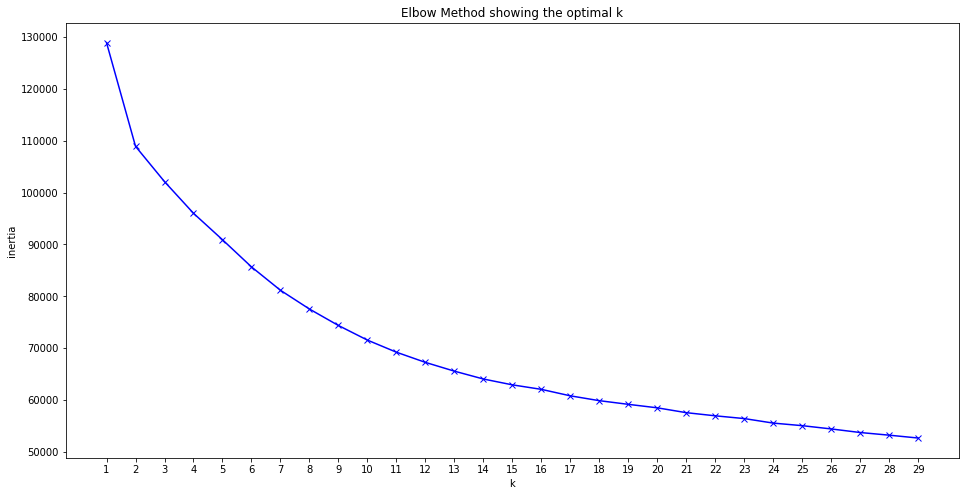

In [63]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

In [66]:
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                   random_state=1234)
    preds = kmeans.fit_predict(to_cluster_scaled)

    score = silhouette_score(to_cluster_scaled, preds)
    silhouette.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(k, score))
    

For n_clusters = 2, silhouette score is 0.20231487976017817)
For n_clusters = 3, silhouette score is 0.1194145450621178)
For n_clusters = 4, silhouette score is 0.12392435494105927)
For n_clusters = 5, silhouette score is 0.1259803294577233)
For n_clusters = 6, silhouette score is 0.10985587892344369)
For n_clusters = 7, silhouette score is 0.11513376259757895)
For n_clusters = 8, silhouette score is 0.12196377149772858)
For n_clusters = 9, silhouette score is 0.12268790163175286)
For n_clusters = 10, silhouette score is 0.12842467255443413)
For n_clusters = 11, silhouette score is 0.12881261714485406)
For n_clusters = 12, silhouette score is 0.1153766880458961)
For n_clusters = 13, silhouette score is 0.11007242360217176)
For n_clusters = 14, silhouette score is 0.11038135098335743)
For n_clusters = 15, silhouette score is 0.10939047865289662)
For n_clusters = 16, silhouette score is 0.11019120858669285)
For n_clusters = 17, silhouette score is 0.10435217179159544)
For n_clusters = 18

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

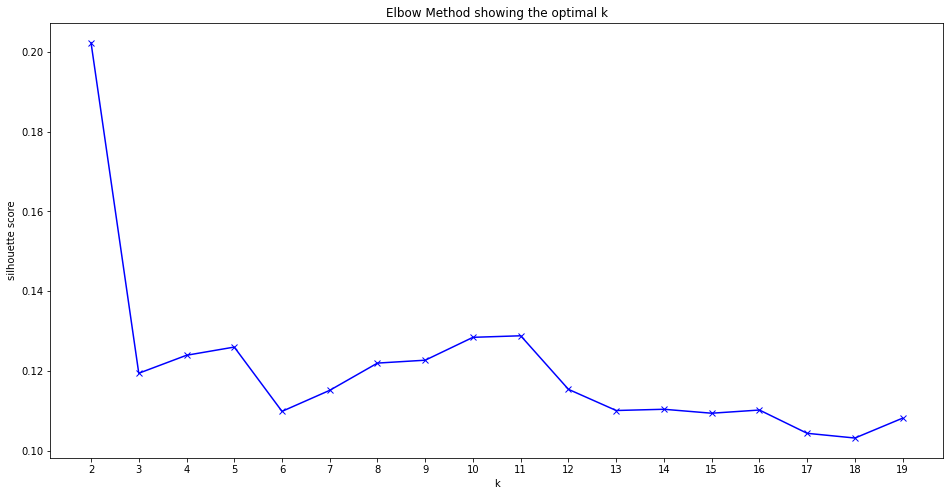

In [67]:
plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

In [68]:
kmeans = KMeans(n_clusters=11)

In [69]:
kmeans.fit(to_cluster_scaled)

KMeans(n_clusters=11)

In [70]:
clustered_ft = kmeans.predict(to_cluster_scaled)

In [71]:
clustered_ft

array([6, 8, 2, ..., 1, 1, 0])

In [72]:
len(clustered_ft)

9916

In [126]:
cluster_col = pd.Series(clustered_ft)

In [127]:
col_to_append = pd.DataFrame(cluster_col)

In [128]:
col_to_append

0
0     6
1     8
2     2
3     9
4     3
...  ..
9911  3
9912  5
9913  1
9914  1
9915  0

[9916 rows x 1 columns]

In [131]:
test_clusters = df_clustered.drop('clusters', axis=1)

In [132]:
final_cluster = test_clusters.dropna()

In [136]:
final_cluster['clusters'] = col_to_append

<ipython-input-136-4c8db29089d0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_cluster['clusters'] = col_to_append


In [137]:
final_cluster

acousticness  danceability  duration_ms  energy  instrumentalness  key  \
0          0.09400         0.310     152560.0   0.445          0.067800  7.0   
1          0.13700         0.419     197707.0   0.565          0.337000  5.0   
2          0.59000         0.354     244285.0   0.302          0.070900  9.0   
3          0.32500         0.727     249940.0   0.785          0.126000  5.0   
4          0.02310         0.571     278320.0   0.724          0.003110  0.0   
...            ...           ...          ...     ...               ...  ...   
9993       0.12300         0.651     200480.0   0.801          0.000000  0.0   
9994       0.08230         0.811     191560.0   0.647          0.681000  0.0   
9995       0.19000         0.686     206293.0   0.610          0.000931  7.0   
9996       0.00824         0.711     200293.0   0.718          0.002080  6.0   
9997       0.00767         0.323     409013.0   0.997          0.110000  1.0   

      liveness  loudness  mode  speechiness    tempo  time_signature  valence  \
0       0.1130   -13.355   0.0       0.0863   95.360             3.0    0.122   
1       0.1280   -11.565   1.0       0.0347  151.277             4.0    0.648   
2       0.1110   -13.078   1.0       0.0326  123.753             4.0    0.223   
3       0.3100    -6.707   0.0       0.0603  129.649             4.0    0.960   
4       0.0919    -5.967   1.0       0.0260  116.755             4.0    0.385   
...        ...       ...   ...          ...      ...             ...      ...   
9993    0.0825    -7.340   1.0       0.0513  133.763             4.0    0.776   
9994    0.0572   -10.989   1.0       0.0498  139.787             4.0    0.990   
9995    0.0710    -5.902   1.0       0.0262   80.567             4.0    0.766   
9996    0.0732    -5.739   1.0       0.0380  117.071             4.0    0.688   
9997    0.9480    -3.440   1.0       0.2640  199.962             4.0    0.315   

      clusters  
0          6.0  
1          8.0  
2          2.0  
3          9.0  
4          3.0  
...        ...  
9993       NaN  
9994       NaN  
9995       NaN  
9996       NaN  
9997       NaN  

[9916 rows x 14 columns]

### Song recommender

In [240]:
def spotify_search(song):
    results = spotify.search(q=song, limit = 1)
    track_uri = []
    for result in results['tracks']['items']:
        track_uri.append(result['uri'])
    return track_uri

In [241]:
def audio_ft(track_uri):
    features = spotify.audio_features(track_uri)
    return features

In [242]:
def scale_userinput(features):
    global input_cluster
    features_df = pd.DataFrame(features)
    features_df = features_df.loc[:,['acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','valence']]
    features_scaled = scaler.transform(features_df)
    input_cluster = kmeans.predict(features_scaled)
    return input_cluster

In [322]:
def match_input(df, cluster_column, input_cluster):
    match = df[df[cluster_column] == input_cluster].sample(1)
    final_match = match['uri']
    return final_match

In [386]:
def uri(z):
    y = pd.DataFrame(z)
    p = y['uri'].values
    track_info = p[0]
    u = spotify.track(track_info)
    print('You might also like',u['name'], 'by', u['album']['artists'][0]['name'])

In [301]:
a = spotify.track('spotify:track:7HfMznwgC4z1ij2dHavHbt')
a['name']

'Made to Love You - Acoustic'

In [216]:
matcher_df1['clusters'] = final_cluster['clusters']
matcher_df1.dropna(inplace = True)
matcher_df1['clusters'] = matcher_df1['clusters'].astype(int)
matcher_df1

<ipython-input-216-bb67125cfa7d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matcher_df1['clusters'] = matcher_df1['clusters'].astype(int)


index  acousticness                                       analysis_url  \
0         0        0.0940  https://api.spotify.com/v1/audio-analysis/33xM...   
1         0        0.1370  https://api.spotify.com/v1/audio-analysis/3Uny...   
2         0        0.5900  https://api.spotify.com/v1/audio-analysis/1w8Q...   
3         0        0.3250  https://api.spotify.com/v1/audio-analysis/7J9m...   
4         0        0.0231  https://api.spotify.com/v1/audio-analysis/1VZe...   
...     ...           ...                                                ...   
9911      0        0.0199  https://api.spotify.com/v1/audio-analysis/4OZE...   
9912      0        0.1100  https://api.spotify.com/v1/audio-analysis/1Tt4...   
9913      0        0.1070  https://api.spotify.com/v1/audio-analysis/76t5...   
9914      0        0.0784  https://api.spotify.com/v1/audio-analysis/4pdP...   
9915      0        0.0152  https://api.spotify.com/v1/audio-analysis/1WP1...   

      danceability  duration_ms  energy                      id  \
0            0.310     152560.0   0.445  33xMbeHzmWd6Od0BmLZEUs   
1            0.419     197707.0   0.565  3UnyplmZaq547hwsfOR5yy   
2            0.354     244285.0   0.302  1w8QCSDH4QobcQeT4uMKLm   
3            0.727     249940.0   0.785  7J9mBHG4J2eIfDAv5BehKA   
4            0.571     278320.0   0.724  1VZedwJj1gyi88WFRhfThb   
...            ...          ...     ...                     ...   
9911         0.611     220573.0   0.700  4OZEu0Vwq0RB2LAq14v99n   
9912         0.671     191600.0   0.314  1Tt4sE4pXi57mTD1GCzsqm   
9913         0.683     187973.0   0.797  76t5B0ttSAje5KHmQbv88t   
9914         0.476     205947.0   0.718  4pdPtRcBmOSQDlJ3Fk945m   
9915         0.746     206880.0   0.754  1WP1r7fuvRqZRnUaTi2I1Q   

      instrumentalness   key  liveness  loudness  mode  speechiness    tempo  \
0              0.06780   7.0    0.1130   -13.355   0.0       0.0863   95.360   
1              0.33700   5.0    0.1280   -11.565   1.0       0.0347  151.277   
2              0.07090   9.0    0.1110   -13.078   1.0       0.0326  123.753   
3              0.12600   5.0    0.3100    -6.707   0.0       0.0603  129.649   
4              0.00311   0.0    0.0919    -5.967   1.0       0.0260  116.755   
...                ...   ...       ...       ...   ...          ...      ...   
9911           0.00000   9.0    0.0549    -5.331   1.0       0.0436  104.981   
9912           0.00000   5.0    0.0825    -8.091   0.0       0.2440  110.898   
9913           0.00000  10.0    0.1140    -4.085   0.0       0.2460   82.916   
9914           0.00001   8.0    0.1220    -5.309   1.0       0.0576  199.864   
9915           0.00000   1.0    0.0486    -6.681   1.0       0.0670  149.882   

      time_signature                                         track_href  \
0                3.0  https://api.spotify.com/v1/tracks/33xMbeHzmWd6...   
1                4.0  https://api.spotify.com/v1/tracks/3UnyplmZaq54...   
2                4.0  https://api.spotify.com/v1/tracks/1w8QCSDH4Qob...   
3                4.0  https://api.spotify.com/v1/tracks/7J9mBHG4J2eI...   
4                4.0  https://api.spotify.com/v1/tracks/1VZedwJj1gyi...   
...              ...                                                ...   
9911             4.0  https://api.spotify.com/v1/tracks/4OZEu0Vwq0RB...   
9912             4.0  https://api.spotify.com/v1/tracks/1Tt4sE4pXi57...   
9913             4.0  https://api.spotify.com/v1/tracks/76t5B0ttSAje...   
9914             4.0  https://api.spotify.com/v1/tracks/4pdPtRcBmOSQ...   
9915             4.0  https://api.spotify.com/v1/tracks/1WP1r7fuvRqZ...   

                type                                   uri  valence  clusters  
0     audio_features  spotify:track:33xMbeHzmWd6Od0BmLZEUs    0.122         6  
1     audio_features  spotify:track:3UnyplmZaq547hwsfOR5yy    0.648         8  
2     audio_features  spotify:track:1w8QCSDH4QobcQeT4uMKLm    0.223         2  
3     audio_features  spotify:track:7J9mBHG4J2eIfDAv5BehKA

# Program

In [389]:
for row in top_songs[['song','artist']].iterrows():
    hot_song = random.choice(top_songs['song'])
    hot_artist = random.choice(top_songs['artist'])
    user_input = input('Enter the name of your favourite song/artist: ')
    if user_input.casefold() in list(top_songs['song'].str.casefold()):
        print('You might also like this song:', hot_song)
        break
    elif user_input.casefold() in list(top_songs['artist'].str.casefold()):
        print('You might also like this artist:', hot_artist)
        break
    elif user_input not in top_songs[['song','artist']].iterrows():
        spotify_search(user_input)
        audio_ft(track_uri)
        scale_userinput(features)
        z = match_input(matcher_df1, 'clusters', input_cluster[0])
        uri(z)
        break

Enter the name of your favourite song/artist: despacito
You might also like Machinehead by Bush


In [ ]:
for row in top_songs[['song','artist']].iterrows():
    hot_song = random.choice(top_songs['song'])
    hot_artist = random.choice(top_songs['artist'])
    user_input = input('Enter the name of your favourite song/artist: ')
    if user_input.casefold() in list(top_songs['song'].str.casefold()):
        print('You might also like this song:', hot_song)
        break
    elif user_input.casefold() in list(top_songs['artist'].str.casefold()):
        print('You might also like this artist:', hot_artist)
        break
    elif user_input not in top_songs[['song','artist']].iterrows():
        spotify_search(user_input)
        audio_ft(track_uri)
        scale_userinput(features)
        z = match_input(matcher_df1, 'clusters', input_cluster[0])
        y = pd.DataFrame(z)
        p = y['uri'].values
        track_info = p[0]
        u = spotify.track(track_info)
        print('You might also like',u['name'], 'by', u['album']['artists'][0]['name'])
        break